In [1]:
import sys; sys.path += ['..', '../src']

Now we should initialize our transformer with learnt embeddings, initialize discriminator and add adversarial loss.
When we are done with that — we are only left with training the thing!

In [2]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split()[:max_len-2] for s in train_src]
train_trg = [s.split()[:max_len-2] for s in train_trg]
val_src = [s.split()[:max_len-2] for s in val_src]
val_trg = [s.split()[:max_len-2] for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [3]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import FFN

transformer = Transformer(len(vocab_src), len(vocab_trg), max_len)
discriminator = FFN(512, 3, 1024)

# Initializing transformer encoder and decoder with embeddings
embeddings_src = load_embeddings('../trained_models/wmt17.en.tok.bpe_cbow.vec')
embeddings_trg = load_embeddings('../trained_models/wmt17.de.tok.bpe_cbow.vec')

init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

7416it [00:01, 6084.20it/s]
10502it [00:01, 6603.38it/s]


In [9]:
from importlib import reload
import src.trainer
reload(src.trainer)

<module 'src.trainer' from '../src/trainer.py'>

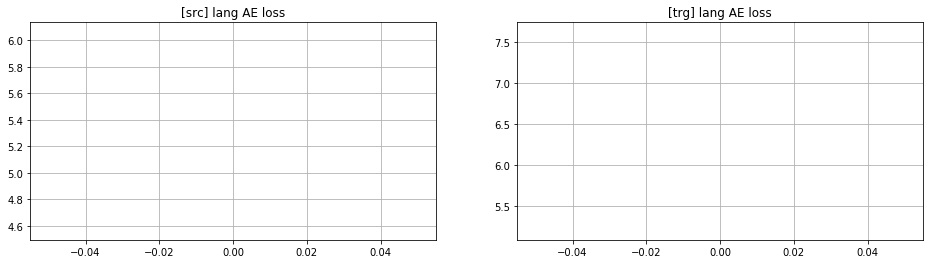

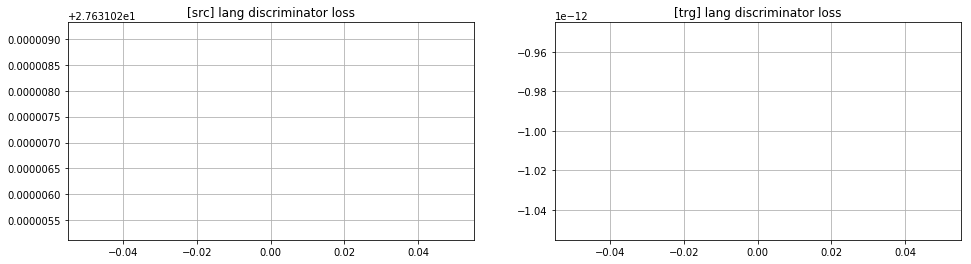

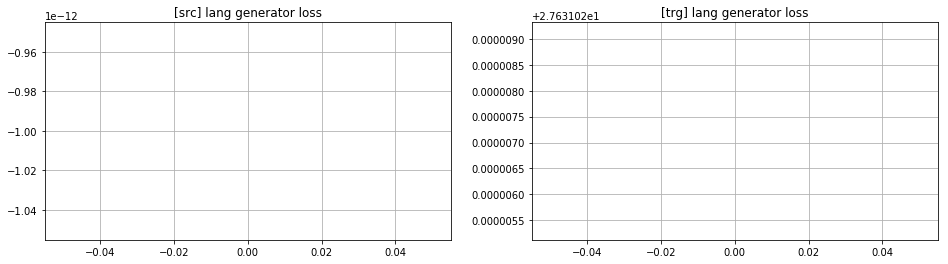

  0%|          | 0/4 [00:00<?, ?it/s]        

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam, RMSprop
from tqdm import tqdm
tqdm.monitor_interval = 0

%matplotlib inline

from src.trainer import Trainer
from src.utils.umt_batcher import UMTBatcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))
adv_criterion = nn.BCELoss()

transformer_optimizer = Adam(transformer.get_trainable_parameters(), lr=3e-4, betas=(0.5, 0.999))
discriminator_optimizer = RMSprop(discriminator.parameters(), lr=5e-4)

training_data = UMTBatcher(train_src_idx[:8], train_trg_idx[:8], vocab_src,
                           vocab_trg, batch_size=2, shuffle=True)
val_data = UMTBatcher(val_src_idx[:2], val_trg_idx[:2], vocab_src,
                      vocab_trg, batch_size=2, shuffle=True)

training_config = {
    'max_num_epochs': 5,
    'start_bt_from_epoch': 1
}

trainer = Trainer(transformer, discriminator,
                  transformer_optimizer, discriminator_optimizer,
                  reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion,
                  training_config)

trainer.run_training(training_data, val_data, plot_every=10)